In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


class Expert(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=[32, 32]):
        super(Expert, self).__init__()
        layers = [nn.Linear(input_size, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers) - 1):
            layers += [nn.Linear(hidden_layers[i], hidden_layers[i + 1]), nn.ReLU()]
        layers += [nn.Linear(hidden_layers[-1], output_size)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class GatingNetwork(nn.Module):
    def __init__(self, input_size, num_experts, hidden_layers=[32, 32]):
        super(GatingNetwork, self).__init__()
        layers = [nn.Linear(input_size, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers) - 1):
            layers += [nn.Linear(hidden_layers[i], hidden_layers[i + 1]), nn.ReLU()]
        layers += [nn.Linear(hidden_layers[-1], num_experts), nn.Softmax(dim=1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [10]:
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"], mnist["target"]
X = X / 255.0
X = X.values.reshape(-1, 28 * 28)
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

In [17]:
import pandas as pd

y_train, _ = pd.factorize(y_train)
y_test, _ = pd.factorize(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = 28 * 28
output_size = 10
num_experts = 4
experts = [Expert(input_size, output_size) for _ in range(num_experts)]
gating_network = GatingNetwork(input_size, num_experts)

/var/folders/lb/x4v1k6xx17344x5164xr7d_w0000gn/T/ipykernel_91188/3929906337.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/lb/x4v1k6xx17344x5164xr7d_w0000gn/T/ipykernel_91188/3929906337.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


In [18]:
def train_moe(experts, gating_network, train_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    expert_optimizers = [optim.Adam(expert.parameters(), lr=lr) for expert in experts]
    gating_optimizer = optim.Adam(gating_network.parameters(), lr=lr)

    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            gating_probabilities = gating_network(inputs)
            for opt in expert_optimizers:
                opt.zero_grad()
            gating_optimizer.zero_grad()
            batch_loss = 0
            for i, expert in enumerate(experts):
                expert_output = expert(inputs)
                expert_loss = criterion(expert_output, labels)
                weighted_loss = gating_probabilities[:, i] * expert_loss
                batch_loss += weighted_loss.mean()
            batch_loss.backward()
            total_loss += batch_loss.item()
            for opt in expert_optimizers:
                opt.step()
            gating_optimizer.step()

        average_loss = total_loss / len(train_loader)
        epoch_losses.append(average_loss)

    return epoch_losses


epoch_losses = train_moe(experts, gating_network, train_loader, epochs=10, lr=0.001)

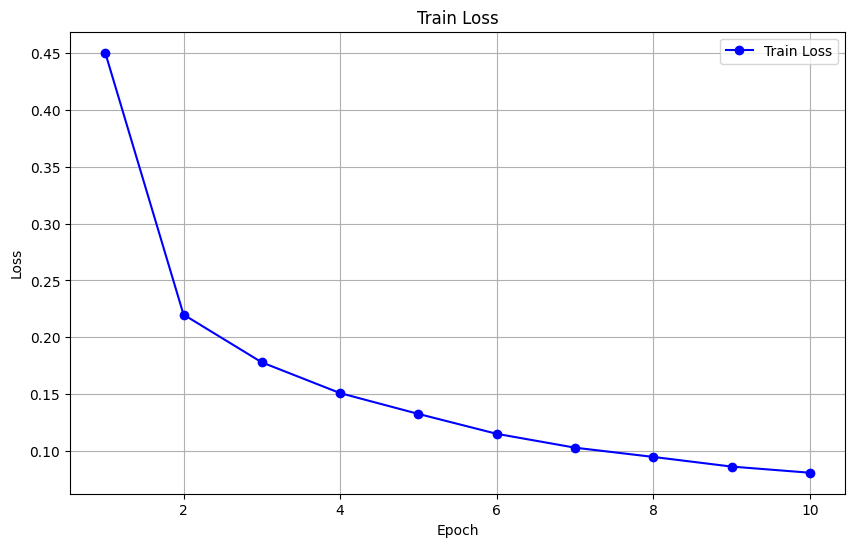

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), epoch_losses, marker="o", color="blue", label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()